# PART 1/3 SCRAPING WIKIPEDIA PAGE

### Use pandas, or the BeautifulSoup package, or any other way you are comfortable with to transform the data in the table on the Wikipedia page into the above pandas dataframe.

In [170]:
# install packages. Installing wikipedia facilitates the data scraping very much, so I could not resist to install it
! pip install wikipedia
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: ...working... done

# All requested packages already installed.



In [172]:
import pandas as pd
import numpy as np
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

In [174]:
link = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df = pd.read_html(link)[0]
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [175]:
# Droping not assigned boroughs:
df = df.drop(df[(df.Borough == "Not assigned")].index)
# Giving "Not assigned" Neighborhoods same name as Borough:
df.Neighborhood.replace("Not assigned", df.Borough, inplace=True)

In [176]:
df.shape

(103, 3)

In [177]:
df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [178]:
# Combining the neighbourhoods with same Postalcode
df2 = df.groupby(['Postal Code','Borough'], sort=False).agg(', '.join)
df2.reset_index(inplace=True)

In [181]:
# checking if all postal codes are unique
print(df2['Postal Code'].nunique())
print(df2.shape)

103
(103, 3)


# PART 2/3 Create DataFrame with coordinates

### Use the Geocoder package or the csv file to create a dataframe with latitude and longitude values

In [182]:
geo = pd.read_csv('https://cocl.us/Geospatial_data')
geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [183]:
# Joining the new table with the previous
df3 = pd.merge(df2,geo,on='Postal Code')
df3.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


# PART 3/3 Explore and cluster the neighborhoods in Toronto

### You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data

In [190]:
# DataFrame that shows the rows where "Toronto" is in Borough
df4 = df3[df3['Borough'].str.contains('Toronto',regex=False)]
df4.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [191]:
df4.shape

(39, 5)

In [188]:
# Using central toronto mean coordinates as reference location
latitude = df4[df4['Borough']=='Central Toronto']['Latitude'].mean()
longitude = df4[df4['Borough']=='Central Toronto']['Longitude'].mean()

In [193]:
# Plotting the map
toronto_map = folium.Map(location=[latitude,longitude],zoom_start=10)

for lat,lng,borough,neighborhood in zip(df4['Latitude'],df4['Longitude'],df4['Borough'],df4['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=4,
    popup=label,
    color='black',
    fill=True,
    fill_color='orange',
    fill_opacity=0.6,
    parse_html=False).add_to(toronto_map)
toronto_map

In [194]:
# DataFrame with coordinates for clustering
X = df4.drop(['Postal Code','Borough','Neighborhood'],axis=1)

In [196]:
# Finding out the optimal k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

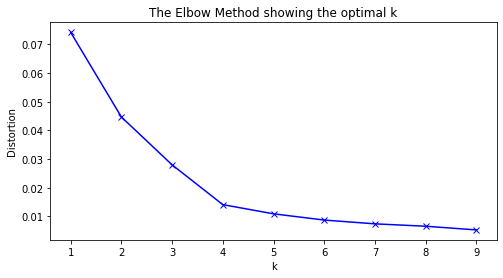

In [197]:
# Plotting the elbow method
plt.figure(figsize=(8,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [198]:
# although not overwhelming, k=4 is a good value according to the elbow method
k=4
kmeans = KMeans(n_clusters = k,random_state=0).fit(X)
df4.insert(0, 'Cluster Labels', kmeans.labels_)
df4.head()

,Cluster Labels,Postal Code,Borough,Neighborhood,Latitude,Longitude
2,3,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,3,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,3,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,0,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [199]:
# creating map
clusters_map = folium.Map(location=[latitude,longitude],zoom_start=11)

# setting color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# adding markers to the map
markers_colors = []
for lat, lon, neighborhood, cluster in zip(df4['Latitude'], df4['Longitude'], df4['Neighborhood'], df4['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(clusters_map)
       
clusters_map